# **Ingesta de datos**

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 

In [2]:
adult = fetch_ucirepo(id=2) 

In [3]:
df = pd.concat([adult.data.features, adult.data.targets], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
mapeo_sex = {'Female': 1, 'Male': 0}
df['sex'] = df['sex'].map(mapeo_sex)

In [5]:
# Columnas categóricas a codificar
columnas_categoricas = ['workclass','education','marital-status','occupation','relationship','native-country']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

In [6]:
# 1) Normaliza la etiqueta: quita espacios y punto final
df['income_clean'] = (
    df['income']
      .astype(str)
      .str.strip()                 # quita espacios al inicio/fin
      .str.replace(r'\.$', '', regex=True)   # elimina punto final si existe
)

# Verifica
print(df['income_clean'].value_counts(dropna=False))

#Reemplazar 
df['income_bin'] = df['income_clean'].map({'>50K': 1, '<=50K': 0})

# Comprueba que no queden NaN por categorías no previstas
print(df['income_bin'].value_counts(dropna=False))

income_clean
<=50K    37155
>50K     11687
Name: count, dtype: int64
income_bin
0    37155
1    11687
Name: count, dtype: int64


In [7]:
# Eliminar la columna 'income' y renombrar 'income_bin' a 'income'
df = df.drop(columns=["income"])
df = df.drop(columns=["income_clean"])
df = df.rename(columns={"income_bin": "income"})

In [8]:
df_tracking = df.copy()

# **Denifir columnas a modelar**

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
import seaborn as sns

<Axes: xlabel='income', ylabel='count'>

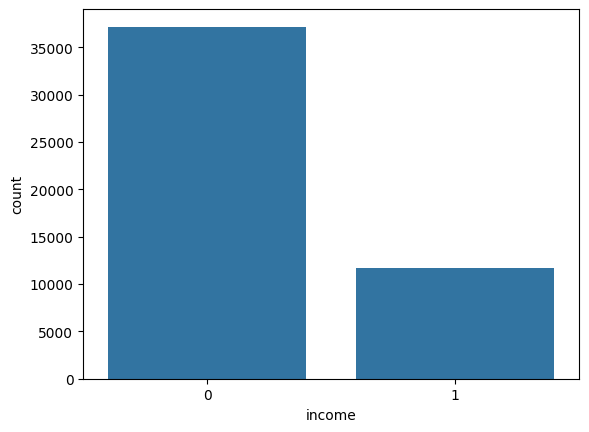

In [10]:
sns.countplot(df, x = "income" )

# **MLFLOW**

In [15]:
from sklearn.feature_extraction import DictVectorizer
import pickle

In [16]:
categorical = [
    'workclass','marital-status','occupation',
    'relationship','native-country'
]
numerical = ['age','education-num','capital-gain','capital-loss','hours-per-week']

In [17]:
df_train, df_val = train_test_split(df, test_size=0.4, random_state=42)

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df_train = df_train.copy()
df_val   = df_val.copy()
df_train["categorical_dict"] = df_train[categorical].to_dict(orient="records")
df_val["categorical_dict"]   = df_val[categorical].to_dict(orient="records")

# Preprocesador: categóricas via DictVectorizer, numéricas con imputación + escala
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", DictVectorizer(), "categorical_dict"),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler())
        ]), numerical),
    ]
)

X_train = preprocessor.fit_transform(df_train)
y_train = df_train["income"].values
X_val   = preprocessor.transform(df_val)
y_val   = df_val["income"].values

Antes ejecutar esto por terminal donde se encuentra el notebook

mlflow server --backend-store-uri sqlite:///backend.db

In [19]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [20]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [21]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:///C:/Users/ASUS/Documents/6_CURSOS/ESPECIALIZACION/Semestre_II/4_APRENDIZAJE_EN_LA_NUBE/ProyectoMLOps/mlruns/8', creation_time=1759789334247, experiment_id='8', last_update_time=1759789334247, lifecycle_stage='active', name='Adult-MLFlow-Orquestacion', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/ASUS/Documents/6_CURSOS/ESPECIALIZACION/Semestre_II/4_APRENDIZAJE_EN_LA_NUBE/ProyectoMLOps/mlruns/7', creation_time=1759780804538, experiment_id='7', last_update_time=1759780804538, lifecycle_stage='active', name='Ingresos-experiment', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/ASUS/Documents/6_CURSOS/ESPECIALIZACION/Semestre_II/4_APRENDIZAJE_EN_LA_NUBE/ProyectoMLOps/mlruns/6', creation_time=1759779667670, experiment_id='6', last_update_time=1759779667670, lifecycle_stage='active', name='Ingresos_Optuna', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/ASUS/Documents/6_CURSOS/ESPECIALIZACION/Semestre_II/4_APREND

## **RANDOM FOREST**

In [23]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

experiment_name = "Ingresos_Clasificacion_RandomForest"
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="RF_balanced"):
    rf = RandomForestClassifier(
        n_estimators=300, 
        random_state=42, 
        max_depth=12,
        n_jobs=-1,
        class_weight="balanced")
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    y_proba = rf.predict_proba(X_val)[:,1] if hasattr(rf, "predict_proba") else None
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    roc  = roc_auc_score(y_val, y_proba) if y_proba is not None else float("nan")   
    
    
    mlflow.log_param("n_estimators", 300)
    mlflow.log_param("max_depth", 12)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_metric("accuracy", acc)
    #rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc)

    mlflow.sklearn.log_model(rf, artifact_path="model")

print(f"RF -> acc:{acc:.3f} f1:{f1:.3f} prec:{prec:.3f} rec:{rec:.3f} roc:{roc:.3f}")

2025/10/07 06:57:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 06:58:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/07 06:58:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RF_balanced at: http://127.0.0.1:5000/#/experiments/3/runs/4eaf76395d3e4ba4ad2adcaf44d454dd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
RF -> acc:0.821 f1:0.697 prec:0.589 rec:0.855 roc:0.917


## **XGBOOST**

In [24]:
import xgboost as xgb

experiment_name = "Ingresos_Xgboost"
mlflow.set_experiment(experiment_name)

# balanceo para XGB
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
spw = n_neg / n_pos

with mlflow.start_run(run_name="XGB_spw"):
    xgb_reg = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=400,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=spw
    )
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    y_proba = xgb_reg.predict_proba(X_val)[:,1]

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    roc  = roc_auc_score(y_val, y_proba)

    mlflow.log_param("scale_pos_weight", round(spw,3))
    mlflow.log_param("n_estimators", 400)
    mlflow.log_param("max_depth", 6)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc)

    mlflow.sklearn.log_model(xgb_reg, artifact_path="model")

print(f"XGB -> acc:{acc:.3f} f1:{f1:.3f} prec:{prec:.3f} rec:{rec:.3f} roc:{roc:.3f}")

2025/10/07 06:58:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 06:58:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/07 06:58:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB_spw at: http://127.0.0.1:5000/#/experiments/2/runs/90fbcecaa08b417e96275328655824c0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
XGB -> acc:0.834 f1:0.711 prec:0.614 rec:0.846 roc:0.924


## **REGRESIÓN LOGISTICA**

In [25]:
from sklearn.linear_model import LogisticRegression

experiment_name = "Ingresos_Logistica"
mlflow.set_experiment(experiment_name)


with mlflow.start_run(run_name="LogReg_balanced"):
    log_reg = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=None,        
        random_state=42
    )
    log_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    if hasattr(log_reg, "predict_proba"):
        y_proba = log_reg.predict_proba(X_val)[:,1]
    else:
        z = log_reg.decision_function(X_val)
        y_proba = (z - z.min()) / (z.max() - z.min() + 1e-9)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    roc  = roc_auc_score(y_val, y_proba)

    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc)

    mlflow.sklearn.log_model(log_reg, artifact_path="model")

print(f"LogReg -> acc:{acc:.3f} f1:{f1:.3f} prec:{prec:.3f} rec:{rec:.3f} roc:{roc:.3f}")

2025/10/07 06:59:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 06:59:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/07 06:59:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogReg_balanced at: http://127.0.0.1:5000/#/experiments/4/runs/6b6503bde10e495991ea322a880c9f7b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4
LogReg -> acc:0.834 f1:0.711 prec:0.614 rec:0.846 roc:0.850


# **Probando autologgin**

In [27]:
import mlflow

experiment_name = "Ingresos_autolog"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

2025/10/07 07:00:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/07 07:00:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/10/07 07:00:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run treasured-wren-423 at: http://127.0.0.1:5000/#/experiments/5/runs/fa2bb159227f4b67b63b9af4af81f8ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


In [28]:
# ----- AUTLOG activado (XGBoost + scikit-learn) -----
mlflow.set_experiment("Ingresos_autolog")
mlflow.autolog()               
mlflow.xgboost.autolog()       

# ----- Balanceo para la clase positiva ( >50K = 1 ) -----
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
spw = n_neg / n_pos

with mlflow.start_run(run_name="XGBClassifier_autolog_spw"):
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",   # clasificación binaria
        eval_metric="logloss",         # para que autolog registre esta métrica
        n_estimators=400,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=spw           # balanceo de clases
    )

    # eval_set hace que MLflow autologue métricas en validación
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predicciones y métricas de CLASIFICACIÓN
    y_pred  = xgb_clf.predict(X_val)
    y_proba = xgb_clf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    roc  = roc_auc_score(y_val, y_proba)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc)

print(f"XGB (autolog) -> acc:{acc:.3f} f1:{f1:.3f} prec:{prec:.3f} rec:{rec:.3f} roc:{roc:.3f}")


2025/10/07 07:00:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/07 07:00:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/10/07 07:00:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:00:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:00:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:00:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run XGBClassifier_autolog_spw at: http://127.0.0.1:5000/#/experiments/5/runs/a5cc18df2c6f4d6682c4b4d25492cde2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
XGB (autolog) -> acc:0.834 f1:0.711 prec:0.614 rec:0.846 roc:0.924


# **OPTUNA**

In [29]:
import optuna

mlflow.set_experiment("Ingresos_Optuna")


def objective(trial):
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)

    # Hiperparámetros que Optuna explorará
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "scale_pos_weight": n_neg / n_pos
    }

    # MLflow registra cada intento como un run
    with mlflow.start_run(nested=True):
        xgb_clf = xgb.XGBClassifier(**param, random_state=42, n_jobs=-1)
        xgb_clf.fit(X_train, y_train)
        y_pred = xgb_clf.predict(X_val)

        f1 = f1_score(y_val, y_pred)
        mlflow.log_metrics({"f1_score": f1})
        mlflow.log_params(param)
    
    return f1  # queremos maximizar F1

# Ejecutar la optimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)  

# 🔹 Resultados
print("Mejores parámetros encontrados:")
print(study.best_params)
print(f"Mejor F1 Score: {study.best_value:.4f}")

# Guardar el mejor modelo en MLflow
with mlflow.start_run(run_name="XGB_Optuna_best"):
    best_model = xgb.XGBClassifier(**study.best_params, random_state=42)
    best_model.fit(X_train, y_train)
    mlflow.xgboost.log_model(best_model, "model_best")


c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-07 07:00:34,775] A new study created in memory with name: no-name-9c0d31ff-0e8c-45fe-a04d-56ef1d4ee88b
2025/10/07 07:00:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:00:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:00:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `depreca

🏃 View run luxuriant-stag-382 at: http://127.0.0.1:5000/#/experiments/6/runs/105025a1a2f04f2b9ed6c9daacb117a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:00:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:00:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:00:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:00:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:00:48,529] Trial 1 finished with value: 0.7108328986263258 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.16073325820180673, 'subsample': 0.7465710054773693, 'colsample_bytree': 0.8194187291

🏃 View run enthused-bass-691 at: http://127.0.0.1:5000/#/experiments/6/runs/ec092f27cad74006a53f1dcb15ae05a2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:00:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:00:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:00:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:00:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:00:55,966] Trial 2 finished with value: 0.709530881453656 and parameters: {'n_estimators': 156, 'max_depth': 9, 'learning_rate': 0.2438672060324192, 'subsample': 0.9845574308436482, 'colsample_bytree': 0.761795848589

🏃 View run judicious-shrike-354 at: http://127.0.0.1:5000/#/experiments/6/runs/a510c1d3b7c34e148f918623e2d49def
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:00:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:00:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:00:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:02,763] Trial 3 finished with value: 0.7138461538461538 and parameters: {'n_estimators': 387, 'max_depth': 6, 'learning_rate': 0.22467412245610074, 'subsample': 0.9800192866376121, 'colsample_bytree': 0.6906610711

🏃 View run melodic-frog-370 at: http://127.0.0.1:5000/#/experiments/6/runs/39d8d70e89ce4735a3507c6be1ae6cd9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:08,423] Trial 4 finished with value: 0.7098994656281133 and parameters: {'n_estimators': 426, 'max_depth': 7, 'learning_rate': 0.08177447571157259, 'subsample': 0.6364968244771652, 'colsample_bytree': 0.9522002915

🏃 View run ambitious-pig-101 at: http://127.0.0.1:5000/#/experiments/6/runs/ebe8130d848a4d17932f904112f0a777
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:14,393] Trial 5 finished with value: 0.7095148078134845 and parameters: {'n_estimators': 395, 'max_depth': 7, 'learning_rate': 0.128140936534158, 'subsample': 0.7880087882871022, 'colsample_bytree': 0.772831262788

🏃 View run dazzling-toad-216 at: http://127.0.0.1:5000/#/experiments/6/runs/c599d4108fa146ae9da16451b1d25076
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:21,152] Trial 6 finished with value: 0.7108753315649867 and parameters: {'n_estimators': 406, 'max_depth': 9, 'learning_rate': 0.2204940000871039, 'subsample': 0.6074217234176689, 'colsample_bytree': 0.63168529724

🏃 View run rare-shrike-841 at: http://127.0.0.1:5000/#/experiments/6/runs/1c5dff0cb9d545e38d6598070ad26d4e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:27,876] Trial 7 finished with value: 0.7075242718446602 and parameters: {'n_estimators': 433, 'max_depth': 4, 'learning_rate': 0.1027719755467907, 'subsample': 0.9138050134684133, 'colsample_bytree': 0.89018615245

🏃 View run marvelous-bird-984 at: http://127.0.0.1:5000/#/experiments/6/runs/a95b8e24f23e43b989d8afbf8d3efffb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:34,611] Trial 8 finished with value: 0.711985377317434 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.08177929812688059, 'subsample': 0.7567738017378397, 'colsample_bytree': 0.86996785494

🏃 View run hilarious-bear-210 at: http://127.0.0.1:5000/#/experiments/6/runs/f6f5496841d5449b9bc378d8f39ee7f5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:40,708] Trial 9 finished with value: 0.6933811050348859 and parameters: {'n_estimators': 490, 'max_depth': 7, 'learning_rate': 0.20291196316129465, 'subsample': 0.8415336065414277, 'colsample_bytree': 0.9615421143

🏃 View run tasteful-donkey-148 at: http://127.0.0.1:5000/#/experiments/6/runs/e8230068db364ceb8d914bb7db5f163e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:46,267] Trial 10 finished with value: 0.7065047701647875 and parameters: {'n_estimators': 317, 'max_depth': 3, 'learning_rate': 0.2920271626642027, 'subsample': 0.9748716290647099, 'colsample_bytree': 0.6220077009

🏃 View run upbeat-bird-600 at: http://127.0.0.1:5000/#/experiments/6/runs/c1c1081d385f4cf2ad3a5e0d41bb8675
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:01:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:01:52,072] Trial 11 finished with value: 0.7081745756841011 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.03609394383858637, 'subsample': 0.7115300368041794, 'colsample_bytree': 0.865385780

🏃 View run receptive-cow-985 at: http://127.0.0.1:5000/#/experiments/6/runs/798d022c13264de282c22bf70c1b035b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:01:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:01:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:01:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:03,279] Trial 12 finished with value: 0.6865 and parameters: {'n_estimators': 323, 'max_depth': 5, 'learning_rate': 0.010295868595768629, 'subsample': 0.6955948924940074, 'colsample_bytree': 0.709408056314113, 'ga

🏃 View run secretive-asp-895 at: http://127.0.0.1:5000/#/experiments/6/runs/a8794539e3c742a2ac0b19dd078c7f54
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:13,290] Trial 13 finished with value: 0.7121993878443376 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.16168854230232232, 'subsample': 0.8056813195903157, 'colsample_bytree': 0.871195846

🏃 View run unequaled-smelt-276 at: http://127.0.0.1:5000/#/experiments/6/runs/108066c6ae8847b2a6ff4d763cd72425
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:20,277] Trial 14 finished with value: 0.7056989433570068 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.1717761507745405, 'subsample': 0.9164688973243746, 'colsample_bytree': 0.7029592498

🏃 View run sassy-shrew-460 at: http://127.0.0.1:5000/#/experiments/6/runs/aecbb0586c0f4fb0bc8841ed7d1c585e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:27,405] Trial 15 finished with value: 0.7068359902728992 and parameters: {'n_estimators': 359, 'max_depth': 5, 'learning_rate': 0.27838849512056274, 'subsample': 0.838398889655495, 'colsample_bytree': 0.8153065572

🏃 View run learned-rat-74 at: http://127.0.0.1:5000/#/experiments/6/runs/79afcfe93139417388eb4a5c9c77d3a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:33,238] Trial 16 finished with value: 0.7076089805189133 and parameters: {'n_estimators': 255, 'max_depth': 10, 'learning_rate': 0.19805719946965103, 'subsample': 0.9486423609647829, 'colsample_bytree': 0.92612931

🏃 View run resilient-sponge-454 at: http://127.0.0.1:5000/#/experiments/6/runs/4641c990a4c04f47b5a64b613a83c348
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:39,028] Trial 17 finished with value: 0.7133556220306176 and parameters: {'n_estimators': 224, 'max_depth': 4, 'learning_rate': 0.2532695924866287, 'subsample': 0.8580772231435678, 'colsample_bytree': 0.7358014861

🏃 View run auspicious-snail-513 at: http://127.0.0.1:5000/#/experiments/6/runs/252cc4f223a743428dfb82522c3ed352
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:44,157] Trial 18 finished with value: 0.7146862951279355 and parameters: {'n_estimators': 224, 'max_depth': 4, 'learning_rate': 0.25529854365628424, 'subsample': 0.8702140449065688, 'colsample_bytree': 0.661903974

🏃 View run rogue-pug-269 at: http://127.0.0.1:5000/#/experiments/6/runs/8616a73956194ea599c848f517ba67a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:49,062] Trial 19 finished with value: 0.7102183406113537 and parameters: {'n_estimators': 474, 'max_depth': 4, 'learning_rate': 0.25481654647305724, 'subsample': 0.9341618103795618, 'colsample_bytree': 0.652998549

🏃 View run peaceful-flea-506 at: http://127.0.0.1:5000/#/experiments/6/runs/de349b422cba4c9cb4c1ab59c187ec59
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:54,053] Trial 20 finished with value: 0.7095196506550219 and parameters: {'n_estimators': 360, 'max_depth': 8, 'learning_rate': 0.22733394070342797, 'subsample': 0.8825899231443305, 'colsample_bytree': 0.682925192

🏃 View run loud-hog-544 at: http://127.0.0.1:5000/#/experiments/6/runs/4ead5a66e6174f57aa0fbb5f77a56b64
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:02:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:02:59,200] Trial 21 finished with value: 0.7105907025515554 and parameters: {'n_estimators': 211, 'max_depth': 4, 'learning_rate': 0.26681766804001955, 'subsample': 0.8608235852189848, 'colsample_bytree': 0.737017763

🏃 View run debonair-panda-387 at: http://127.0.0.1:5000/#/experiments/6/runs/2c1f54e9415345528a40b2c346a9034c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:02:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:02:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:02:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:03:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:03:04,340] Trial 22 finished with value: 0.7083042568039079 and parameters: {'n_estimators': 207, 'max_depth': 3, 'learning_rate': 0.2979010542969198, 'subsample': 0.9985726101571334, 'colsample_bytree': 0.6002108443

🏃 View run merciful-zebra-855 at: http://127.0.0.1:5000/#/experiments/6/runs/8f75540dc66848c098058e9de918d83f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:03:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:03:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:03:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:03:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:03:08,962] Trial 23 finished with value: 0.7092037409317368 and parameters: {'n_estimators': 266, 'max_depth': 4, 'learning_rate': 0.23786104216975867, 'subsample': 0.7996770946074151, 'colsample_bytree': 0.654558619

🏃 View run colorful-mule-748 at: http://127.0.0.1:5000/#/experiments/6/runs/cd28c9afff97422086b60eb69ca4d5f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


2025/10/07 07:03:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:03:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:03:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:03:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-07 07:03:15,213] Trial 24 finished with value: 0.7108870611125852 and parameters: {'n_estimators': 193, 'max_depth': 6, 'learning_rate': 0.20651346201582538, 'subsample': 0.8894893780262787, 'colsample_bytree': 0.728934467

🏃 View run whimsical-chimp-959 at: http://127.0.0.1:5000/#/experiments/6/runs/a8816365409f427081ea92fb933fdc64
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Mejores parámetros encontrados:
{'n_estimators': 224, 'max_depth': 4, 'learning_rate': 0.25529854365628424, 'subsample': 0.8702140449065688, 'colsample_bytree': 0.6619039743747405, 'gamma': 2.136064468682056}
Mejor F1 Score: 0.7147


2025/10/07 07:03:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:03:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:03:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:03:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/07 07:03:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xg

🏃 View run XGB_Optuna_best at: http://127.0.0.1:5000/#/experiments/6/runs/06bf52a2a2564f65a5a94ce6c68722f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


In [30]:
study.best_params

{'n_estimators': 224,
 'max_depth': 4,
 'learning_rate': 0.25529854365628424,
 'subsample': 0.8702140449065688,
 'colsample_bytree': 0.6619039743747405,
 'gamma': 2.136064468682056}

# **SERVIDOR TRACKING**

duration-prediction

mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 5000

In [31]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Ingresos-experiment")

<Experiment: artifact_location='file:///C:/Users/ASUS/Documents/6_CURSOS/ESPECIALIZACION/Semestre_II/4_APRENDIZAJE_EN_LA_NUBE/ProyectoMLOps/mlruns/7', creation_time=1759780804538, experiment_id='7', last_update_time=1759780804538, lifecycle_stage='active', name='Ingresos-experiment', tags={}>

In [32]:
import pickle
from pathlib import Path
import numpy as np
import mlflow
import mlflow.xgboost
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# 1) Tracking (apunta al server ya levantado)
#mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Adult-MLFlow-Orquestacion")

# 2) Definir features correctamente
categorical = ['workclass','marital-status','occupation',
               'relationship','native-country']  # categóricas
numerical   = ['age','education-num','capital-gain','capital-loss','hours-per-week']  # numéricas

# 3) Split estratificado
df_train_orq, df_val_orq = train_test_split(df, test_size=0.4, random_state=42, stratify=df['income'])

# 4) DictVectorizer 
dv = DictVectorizer()

train_dicts = (df_train_orq[categorical].astype(str)
               .assign(**df_train_orq[numerical])
               .to_dict(orient='records'))
X_train = dv.fit_transform(train_dicts)
y_train = df_train_orq['income'].values  # 0/1

val_dicts = (df_val_orq[categorical].astype(str)
             .assign(**df_val_orq[numerical])
             .to_dict(orient='records'))
X_val = dv.transform(val_dicts)
y_val = df_val_orq['income'].values

# 5) Balanceo para XGBoost
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
spw = n_neg / n_pos

# 6) Entrenar XGBClassifier y registrar en MLflow
models_folder = Path('models')
models_folder.mkdir(exist_ok=True)

with mlflow.start_run(run_name="xgb_classifier_dictvec"):
    params = {
        'n_estimators': 333,
        'max_depth': 9,
        'learning_rate': 0.06927659202446733,
        'subsample': 0.7384018543749307,
        'colsample_bytree': 0.7456148148748957,
        'gamma': 3.131133258823818,
        #modelo binario
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': spw,
        'n_jobs': -1,
        'random_state': 42,
    }

    xgb_clf = xgb.XGBClassifier(**params)
    # opcional: eval_set para que autolog registre métricas de validación si activas mlflow.xgboost.autolog()
    xgb_clf.fit(X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=False
    )

    # 7) Métricas de clasificación
    y_pred  = xgb_clf.predict(X_val)
    y_proba = xgb_clf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    roc  = roc_auc_score(y_val, y_proba)

    # 8) Log en MLflow
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc)

    # 9) Guardar y loguear el preprocesador (DictVectorizer)
    with open(models_folder / "preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact(str(models_folder / "preprocessor.b"), artifact_path="preprocessor")

    # 10) Guardar el modelo
    mlflow.xgboost.log_model(xgb_clf, artifact_path="model_mlflow")

print(f"XGB | acc:{acc:.3f} f1:{f1:.3f} prec:{prec:.3f} rec:{rec:.3f} roc:{roc:.3f}")


2025/10/07 07:03:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 07:03:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [07:03:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/07 07:03:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/07 07:03:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\ASUS\Documents\6_CURSOS\ESPECIALIZACION\Semestre_II\4_APRENDIZAJE_EN_LA_NUBE\ProyectoMLOps\.venv\Lib\site-packages\xg

🏃 View run xgb_classifier_dictvec at: http://localhost:5000/#/experiments/8/runs/c95b177611e74c8a9330a6655556fc62
🧪 View experiment at: http://localhost:5000/#/experiments/8
XGB | acc:0.835 f1:0.712 prec:0.612 rec:0.851 roc:0.929
